# Part 3 Building a CNN by minazmeh and aramired


##  Note 1:  
    There are 36 classes where 0-9 classes are indeed 0-9, and 10-35 are A-Z
           This Information is essential when we are plotting the confusion matrix and ROC 

## Note 2: 
    We have reused the same code with slight modification from our part2 improvements section. Therefore, we do not have any new improvement models other than the ones we already performed in Part II
    
## Note 3:
    The best model according to us is Learning Rate Scheduler, we have plotted the required visuals and information for each of the imrpvement methods we have done yet. So The visuals are available for all of the improvement models including the basic CNN 

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import warnings
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import torch
import torch.optim as optim
from tqdm import tqdm
import time
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import torch.optim.lr_scheduler as lr_scheduler

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cpu')

---

# Preprocess

In [5]:
transform = transforms.Compose([
    transforms.Resize((28, 28)), 
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = ImageFolder(root='cnn_dataset', transform=transform)


train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.1 * len(dataset))    # 10% for validation
test_size = len(dataset) - train_size - val_size  # 20% for test
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
dataset

Dataset ImageFolder
    Number of datapoints: 100800
    Root location: cnn_dataset
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [7]:
print("Number of classes:", len(dataset.classes))
print("Classes:", dataset.classes)
print("Total samples:", len(dataset))

data_iter = iter(train_loader)
images, labels = next(data_iter)
print("Batch size:", images.shape)
print("Labels:", labels[:10])


Number of classes: 36
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Total samples: 100800
Batch size: torch.Size([64, 1, 28, 28])
Labels: tensor([29, 25,  7, 17, 29, 26,  1, 24,  3, 15])


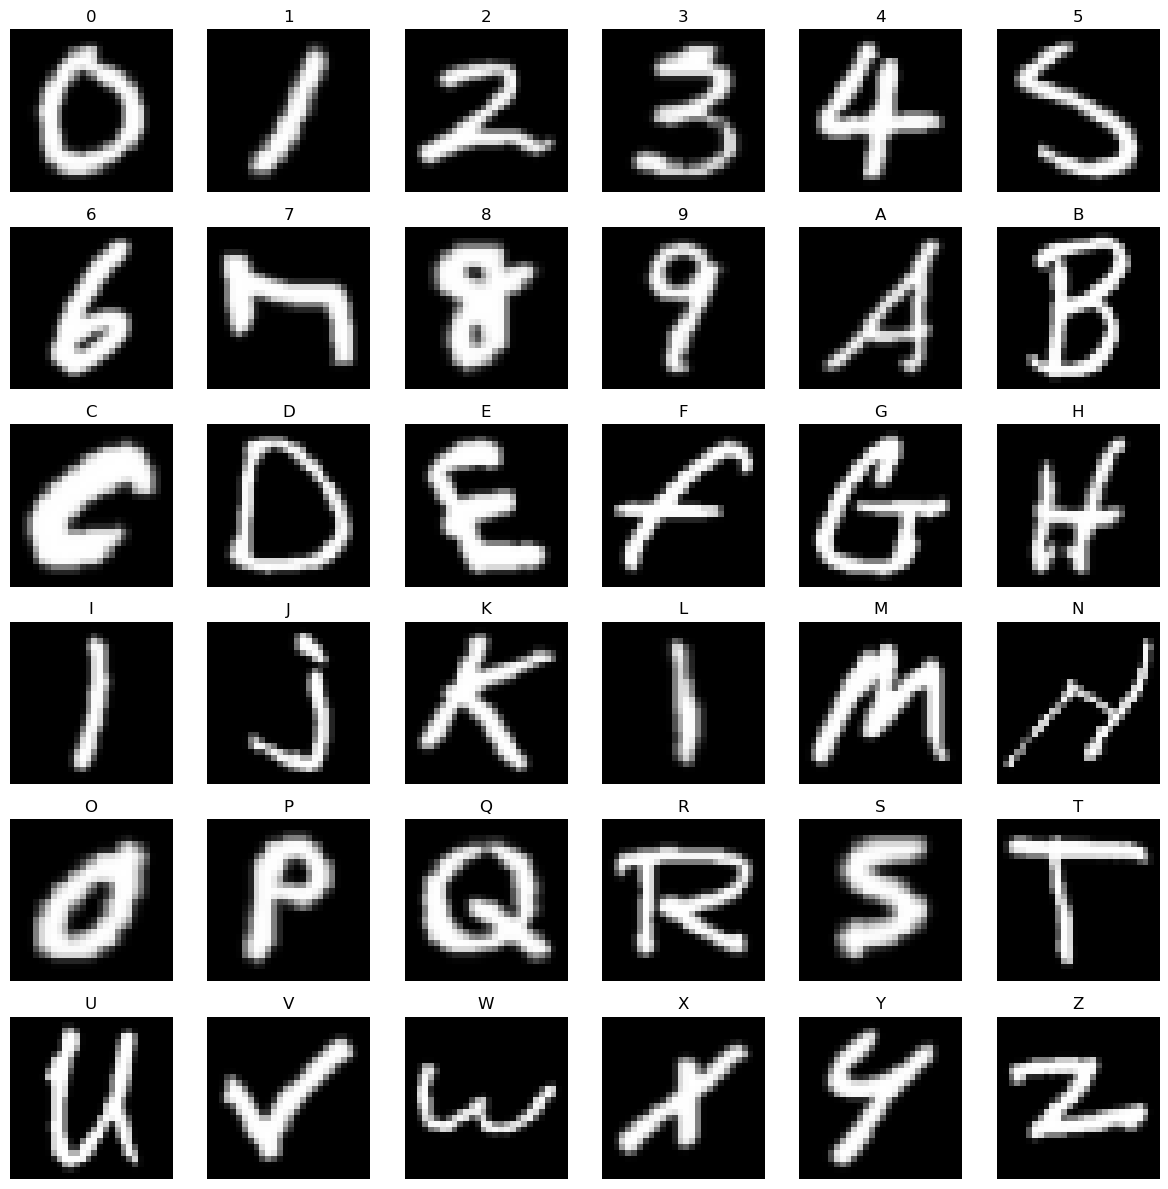

In [8]:
def scale_for_display(img):
    img_min, img_max = img.min(), img.max()
    return (img - img_min) / (img_max - img_min)

class_names = dataset.classes
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(12, 12))

displayed_categories = set()
i = 0

# displayy one sample from each class
for img, label in dataset:
    if label not in displayed_categories:
        ax = axes[i // 6, i % 6]
        img = scale_for_display(img)  #scale krna tha.. display nhi ho rha
        ax.imshow(img.permute(1, 2, 0).squeeze(), cmap='gray' if img.shape[0] == 1 else None)
        ax.set_title(class_names[label])
        ax.axis('off')
        displayed_categories.add(label)
        i += 1

    if len(displayed_categories) >= 36:
        break

plt.tight_layout()
plt.show()


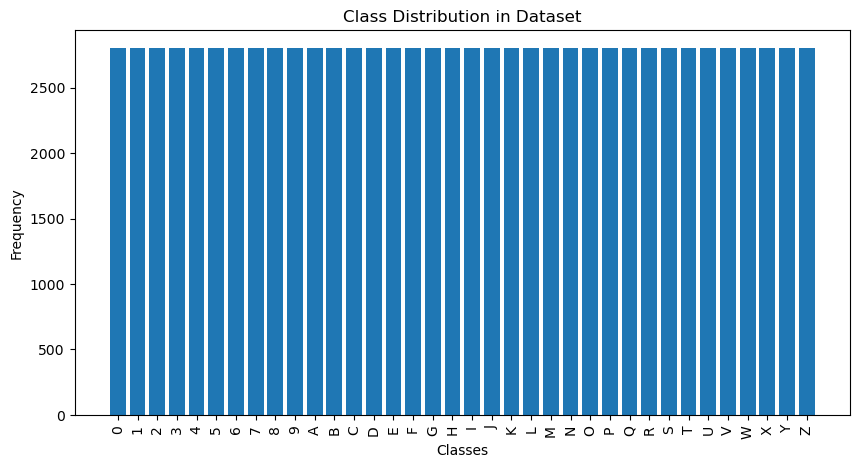

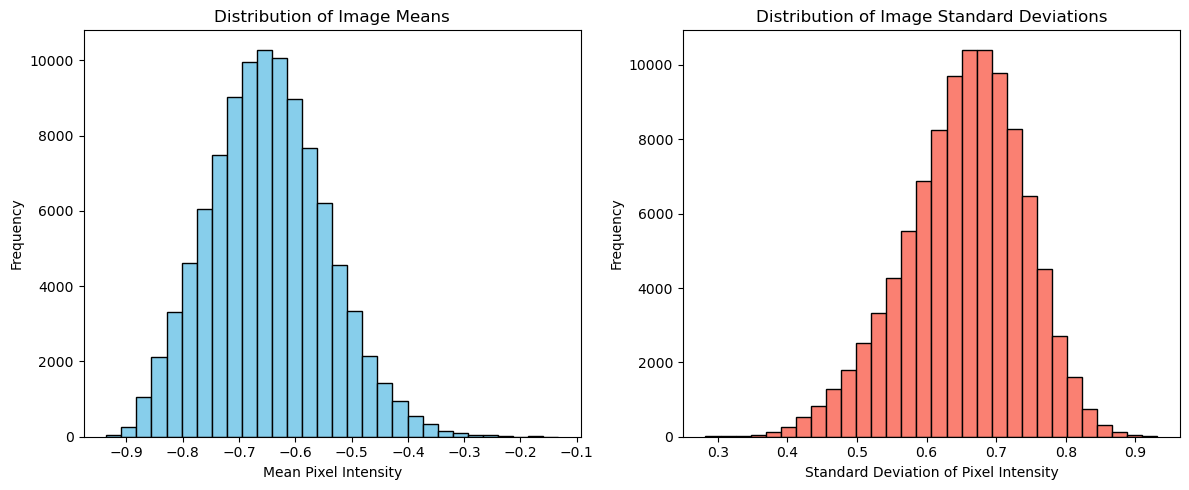

In [9]:
class_counts = np.bincount([label for _, label in dataset], minlength=len(dataset.classes))
plt.figure(figsize=(10, 5))
plt.bar(range(len(dataset.classes)), class_counts, tick_label=dataset.classes)
plt.title("Class Distribution in Dataset")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()


means, stds = [], []
for img, _ in dataset:
    means.append(img.mean().item())
    stds.append(img.std().item())

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(means, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Image Means")
plt.xlabel("Mean Pixel Intensity")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(stds, bins=30, color='salmon', edgecolor='black')
plt.title("Distribution of Image Standard Deviations")
plt.xlabel("Standard Deviation of Pixel Intensity")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [ ]:
# helper methods for further plottings

In [11]:
def calculate_metrics(labels, preds):
    accuracy = accuracy_score(labels, preds) * 100
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    return accuracy, precision, recall, f1

def evaluate_model_test(loader):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    avg_loss = running_loss / len(loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy, all_labels, all_preds




---

---

# BASIC CNN

- **How many input neurons are there?**
  - The input size is 28x28 pixels with 1 channel, so there are 784 input neurons in total (flattened).

- **How many output neurons are there?**
  - There are 36 output neurons, representing 36 possible classes.

- **What activation function is used for the hidden layers?**
  - ReLU is used as the activation function for all hidden layers.

- **What activation function is used for the output layer?**
  - The output layer has no explicit activation function, as `CrossEntropyLoss` applies Softmax internally.

- **What is the number of hidden layers?**
  - The model has 9 hidden layers.

- **What is the size of each hidden layer?**
  - The hidden layers consist of 4 convolutional layers with 32, 64, 128, and 256 filters, and 1 fully connected layer with 512 neurons.

- **Do you include Dropout? (details)**
  - Yes, Dropout with a probability of 0.5 is applied after the fully connected layer `fc1` to prevent overfitting.


In [12]:
class CNN_basic(nn.Module):
    def __init__(self, num_classes=36):
        super(CNN_basic, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5)
        
        self.fc1 = nn.Linear(256 * 1 * 1, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        
        x = x.view(-1, 256 * 1 * 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = self.fc2(x)
        return x

model = CNN_basic(num_classes=36)

summary(model, input_size=(64, 1, 28, 28))


Layer (type:depth-idx)                   Output Shape              Param #
CNN_basic                                [64, 36]                  --
├─Conv2d: 1-1                            [64, 32, 28, 28]          320
├─MaxPool2d: 1-2                         [64, 32, 14, 14]          --
├─Conv2d: 1-3                            [64, 64, 14, 14]          18,496
├─MaxPool2d: 1-4                         [64, 64, 7, 7]            --
├─Conv2d: 1-5                            [64, 128, 7, 7]           73,856
├─MaxPool2d: 1-6                         [64, 128, 3, 3]           --
├─Conv2d: 1-7                            [64, 256, 3, 3]           295,168
├─MaxPool2d: 1-8                         [64, 256, 1, 1]           --
├─Linear: 1-9                            [64, 512]                 131,584
├─Dropout: 1-10                          [64, 512]                 --
├─Linear: 1-11                           [64, 36]                  18,468
Total params: 537,892
Trainable params: 537,892
Non-trainable 

In [13]:
basic_cnn_metrics = {
    "train_loss": [],
    "train_accuracy": [],
    "val_loss": [],
    "val_accuracy": [],
    "test_loss": None,
    "test_accuracy": None,
    "training_time": None,
    "test_precision": 0,
    "test_recall": 0,
    "test_f1": 0
}

In [14]:
num_epochs = 10
learning_rate = 0.001
model = CNN_basic(num_classes=36).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def evaluate_model(loader):
    model.eval()  #evaluation mode
    correct = 0
    total = 0
    running_loss = 0.0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = running_loss / len(loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [15]:
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        #training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    #training loss and accuracy for this epoch
    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    
    #Validation
    val_loss, val_accuracy = evaluate_model(val_loader)
    
    
    basic_cnn_metrics["train_loss"].append(avg_train_loss)
    basic_cnn_metrics["train_accuracy"].append(train_accuracy)
    basic_cnn_metrics["val_loss"].append(val_loss)
    basic_cnn_metrics["val_accuracy"].append(val_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

end_time = time.time()
basic_cnn_metrics["training_time"] = end_time - start_time
print(f"Total training time: {basic_cnn_metrics['training_time']:.2f} seconds")

print("Training complete...")

Epoch 1/10: 100%|██████████| 1103/1103 [00:56<00:00, 19.69it/s]


Epoch [1/10], Train Loss: 0.7052, Train Accuracy: 77.20%, Val Loss: 0.3495, Val Accuracy: 87.73%


Epoch 2/10: 100%|██████████| 1103/1103 [00:56<00:00, 19.63it/s]


Epoch [2/10], Train Loss: 0.3131, Train Accuracy: 88.70%, Val Loss: 0.2751, Val Accuracy: 89.50%


Epoch 3/10: 100%|██████████| 1103/1103 [00:57<00:00, 19.26it/s]


Epoch [3/10], Train Loss: 0.2667, Train Accuracy: 89.98%, Val Loss: 0.2694, Val Accuracy: 89.80%


Epoch 4/10: 100%|██████████| 1103/1103 [00:57<00:00, 19.22it/s]


Epoch [4/10], Train Loss: 0.2408, Train Accuracy: 90.91%, Val Loss: 0.2575, Val Accuracy: 90.50%


Epoch 5/10: 100%|██████████| 1103/1103 [00:57<00:00, 19.10it/s]


Epoch [5/10], Train Loss: 0.2245, Train Accuracy: 91.29%, Val Loss: 0.2657, Val Accuracy: 90.45%


Epoch 6/10: 100%|██████████| 1103/1103 [00:58<00:00, 18.78it/s]


Epoch [6/10], Train Loss: 0.2047, Train Accuracy: 92.05%, Val Loss: 0.2722, Val Accuracy: 90.01%


Epoch 7/10: 100%|██████████| 1103/1103 [00:59<00:00, 18.62it/s]


Epoch [7/10], Train Loss: 0.1918, Train Accuracy: 92.37%, Val Loss: 0.2551, Val Accuracy: 90.47%


Epoch 8/10: 100%|██████████| 1103/1103 [00:58<00:00, 18.88it/s]


Epoch [8/10], Train Loss: 0.1826, Train Accuracy: 92.63%, Val Loss: 0.2609, Val Accuracy: 90.92%


Epoch 9/10: 100%|██████████| 1103/1103 [00:59<00:00, 18.59it/s]


Epoch [9/10], Train Loss: 0.1750, Train Accuracy: 92.88%, Val Loss: 0.2529, Val Accuracy: 91.41%


Epoch 10/10: 100%|██████████| 1103/1103 [01:00<00:00, 18.34it/s]


Epoch [10/10], Train Loss: 0.1646, Train Accuracy: 93.16%, Val Loss: 0.2821, Val Accuracy: 90.67%
Total training time: 625.67 seconds
Training complete...


In [16]:
test_loss, test_accuracy, test_labels, test_preds = evaluate_model_test(test_loader)
acc, test_precision, test_recall, test_f1 = calculate_metrics(test_labels, test_preds)

basic_cnn_metrics["test_loss"] = test_loss
basic_cnn_metrics["test_accuracy"] = test_accuracy
basic_cnn_metrics["train_loss"].append(avg_train_loss)
basic_cnn_metrics["train_accuracy"].append(train_accuracy)
basic_cnn_metrics["val_loss"].append(val_loss)
basic_cnn_metrics["val_accuracy"].append(val_accuracy)
basic_cnn_metrics["test_precision"] = test_precision
basic_cnn_metrics["test_recall"] = test_recall
basic_cnn_metrics["test_f1"] = test_f1

print(f"Test Loss: {test_loss:.4f} and Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.2787 and Test Accuracy: 90.77%


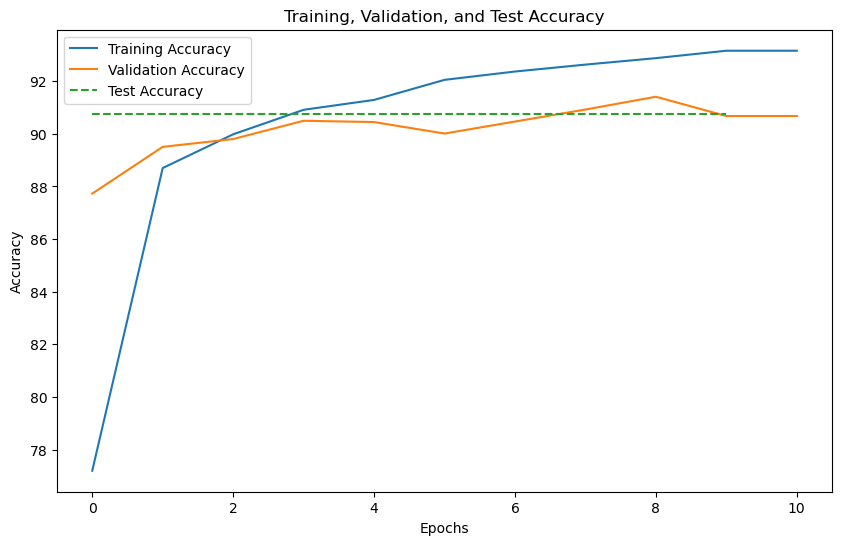

In [17]:

test_accuracy_repeated = [basic_cnn_metrics['test_accuracy']] * num_epochs

plt.figure(figsize=(10, 6))
plt.plot(basic_cnn_metrics['train_accuracy'], label='Training Accuracy')
plt.plot(basic_cnn_metrics['val_accuracy'], label='Validation Accuracy')
plt.plot(test_accuracy_repeated, label='Test Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()
plt.show()


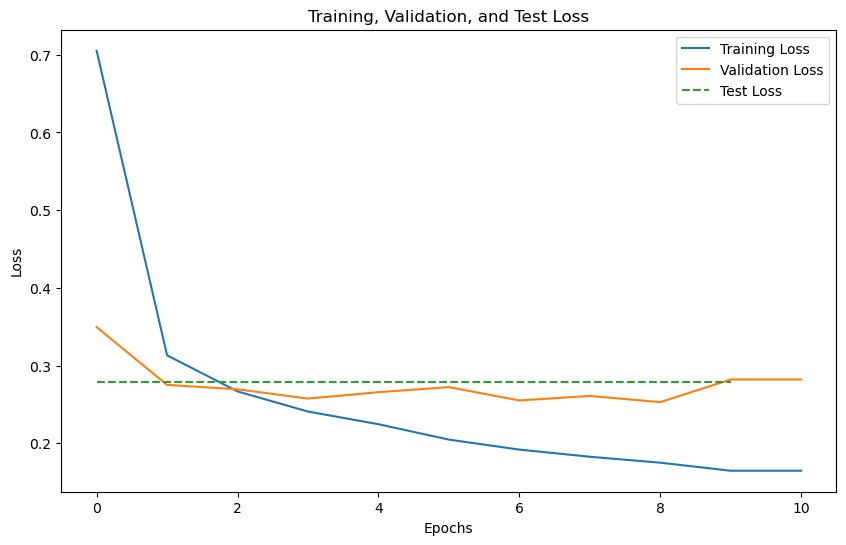

In [18]:
test_loss_repeated = [basic_cnn_metrics['test_loss']] * 10

plt.figure(figsize=(10, 6))
plt.plot(basic_cnn_metrics['train_loss'], label='Training Loss')
plt.plot(basic_cnn_metrics['val_loss'], label='Validation Loss')
plt.plot(test_loss_repeated, label='Test Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.show()


In [19]:
num_classes = 36 
y_true = []
y_pred = []
y_score = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        probabilities = torch.softmax(outputs, dim=1)
        y_score.extend(probabilities.cpu().numpy()) 
        y_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy()) 
        y_true.extend(labels.cpu().numpy())

In [ ]:
# Note: There are 36 classes where 0-9 classes are indeed 0-9, and 10-35 are A-Z

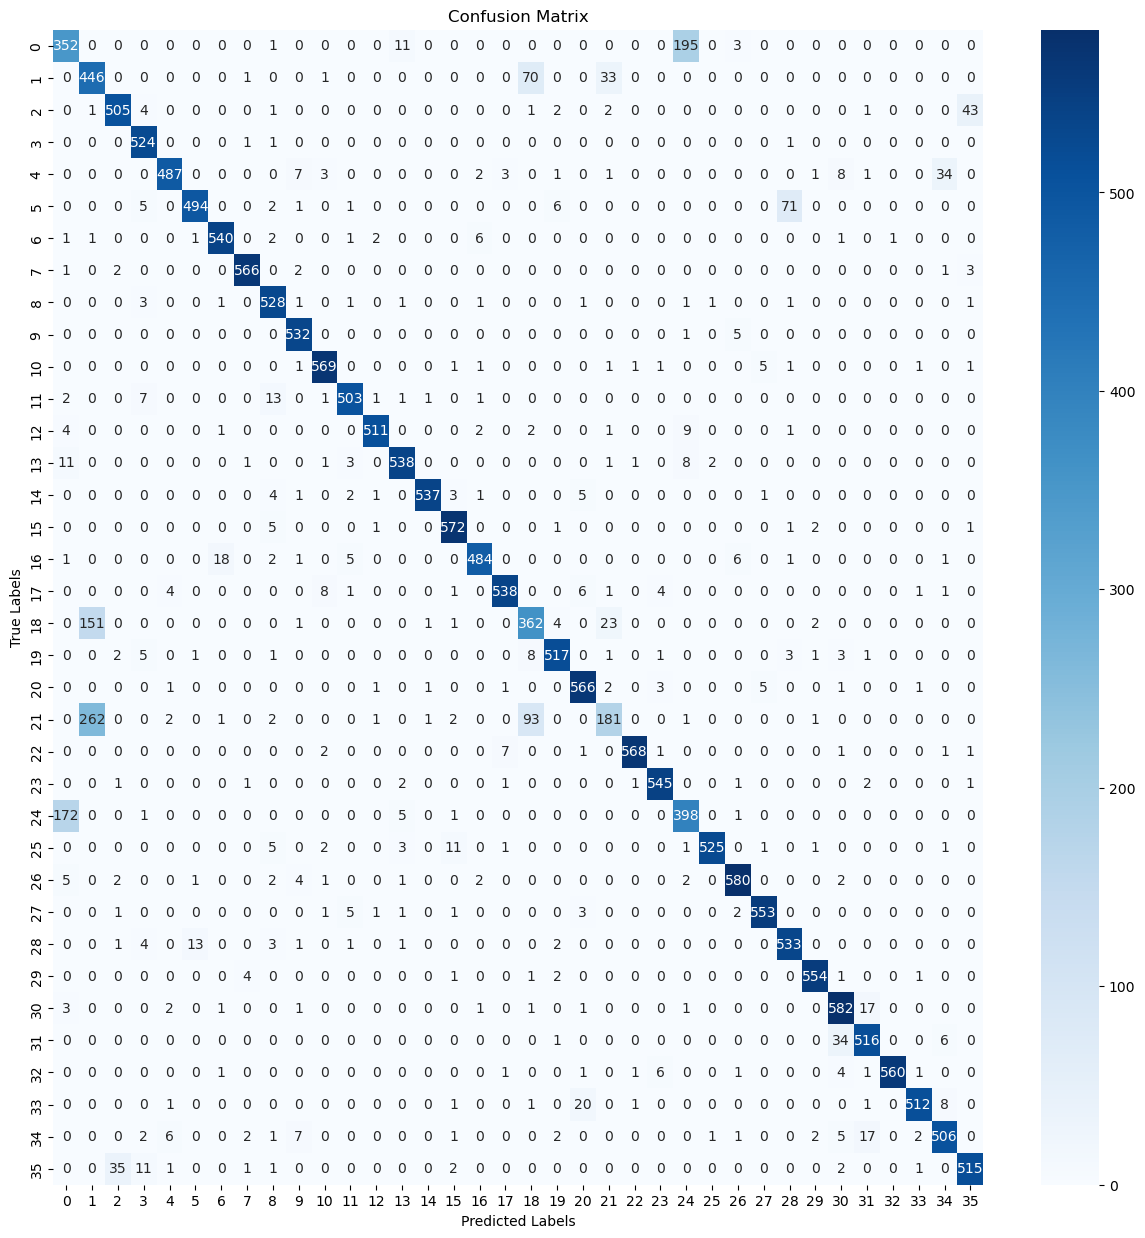

In [20]:
plt.figure(figsize=(15, 15))
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

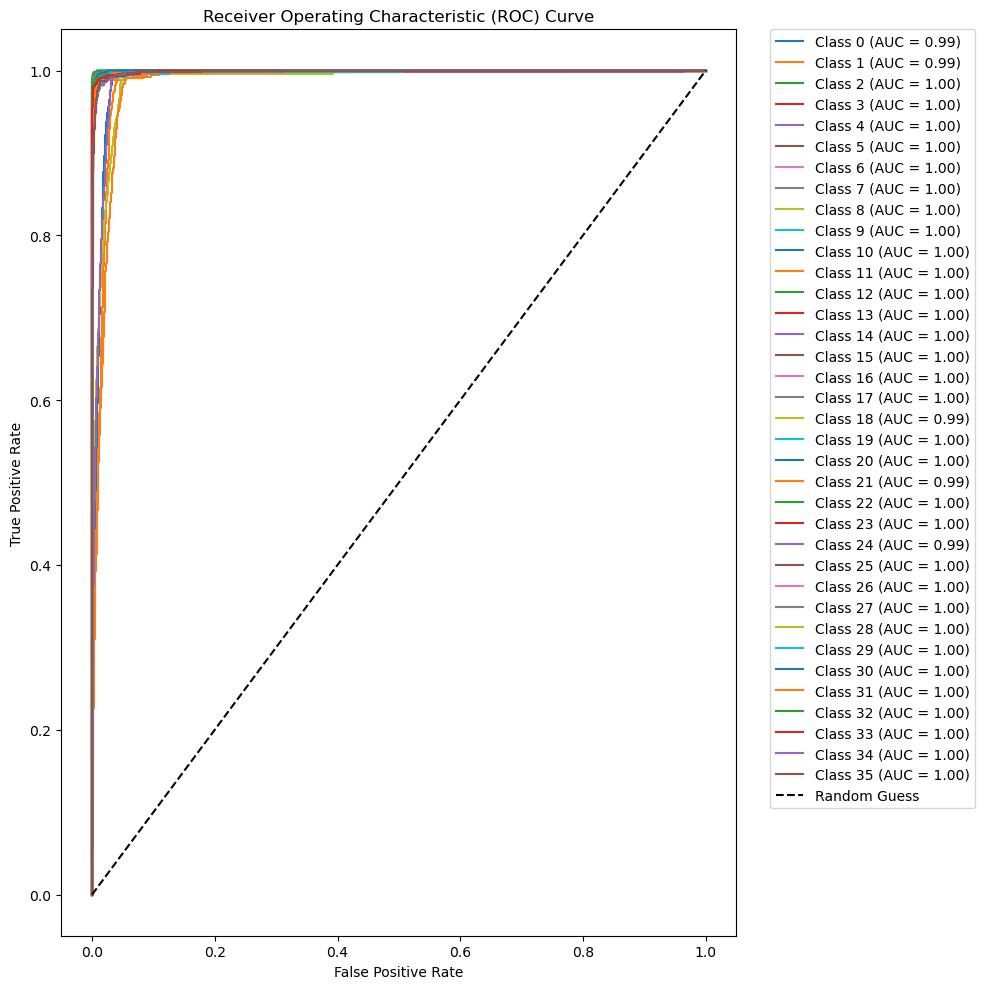

In [21]:
num_classes = len(set(y_true))
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
y_score = np.array(y_score)

plt.figure(figsize=(10, 10))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

#random guess
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

In [22]:
basic_cnn_metrics

{'train_loss': [0.705243539230616,
  0.31314400830732514,
  0.2667155395635992,
  0.24079087549856004,
  0.22449971074517056,
  0.2046726516203943,
  0.1918139873496371,
  0.18260367468576996,
  0.17497020564696406,
  0.1646261083068544,
  0.1646261083068544],
 'train_accuracy': [77.19671201814059,
  88.69897959183673,
  89.98157596371883,
  90.91269841269842,
  91.28826530612245,
  92.05073696145125,
  92.36678004535148,
  92.63038548752834,
  92.87556689342404,
  93.1575963718821,
  93.1575963718821],
 'val_loss': [0.3494862274184257,
  0.2750693507068142,
  0.2694344745265155,
  0.25747663709276086,
  0.2657271979871807,
  0.2722251864173744,
  0.2550655642076384,
  0.26085756080154376,
  0.2529449882280506,
  0.28207127533004256,
  0.28207127533004256],
 'val_accuracy': [87.72817460317461,
  89.50396825396825,
  89.8015873015873,
  90.49603174603175,
  90.44642857142857,
  90.00992063492063,
  90.46626984126983,
  90.92261904761905,
  91.40873015873017,
  90.67460317460318,
  90.67

---

---

# IMPROVEMENT MODELS (EARLY STOPPING, KFOLDS, LEARNING RATE SCHEDULER)

# Early stopping - IMPROVEMENT #1

In [23]:
patience = 3 
best_val_loss = float("inf")
epochs_without_improvement = 0

early_stopping_metrics = {
    "best_val_loss": best_val_loss,
    "best_epoch": 0,
    "epochs_without_improvement": epochs_without_improvement,
    "train_loss": [],
    "train_accuracy": [],
    "val_loss": [],
    "val_accuracy": [],
    "total_training_time": None,
    "test_precision":0,
    "test_recall":0,
    "test_f1":0
}

In [24]:
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    
    val_loss, val_accuracy = evaluate_model(val_loader)

    early_stopping_metrics["train_loss"].append(avg_train_loss)
    early_stopping_metrics["train_accuracy"].append(train_accuracy)
    early_stopping_metrics["val_loss"].append(val_loss)
    early_stopping_metrics["val_accuracy"].append(val_accuracy)

    if val_loss < early_stopping_metrics["best_val_loss"]:
        early_stopping_metrics["best_val_loss"] = val_loss
        early_stopping_metrics["epochs_without_improvement"] = 0
        early_stopping_metrics["best_epoch"] = epoch + 1
        best_model_state = model.state_dict()
    else:
        early_stopping_metrics["epochs_without_improvement"] += 1

    if early_stopping_metrics["epochs_without_improvement"] >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        model.load_state_dict(best_model_state)
        break

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

torch.save(model.state_dict(), "earlystopping.pt")

end_time = time.time()
early_stopping_metrics["total_training_time"] = end_time - start_time
print(f"Total training time: {early_stopping_metrics['total_training_time']:.2f} seconds")


Epoch 1/10: 100%|██████████| 1103/1103 [00:59<00:00, 18.43it/s]


Epoch [1/10], Train Loss: 0.1600, Train Accuracy: 93.42%, Val Loss: 0.2728, Val Accuracy: 91.02%


Epoch 2/10: 100%|██████████| 1103/1103 [00:59<00:00, 18.42it/s]


Epoch [2/10], Train Loss: 0.1509, Train Accuracy: 93.70%, Val Loss: 0.2818, Val Accuracy: 91.16%


Epoch 3/10: 100%|██████████| 1103/1103 [01:00<00:00, 18.35it/s]


Epoch [3/10], Train Loss: 0.1486, Train Accuracy: 93.81%, Val Loss: 0.3040, Val Accuracy: 90.31%


Epoch 4/10: 100%|██████████| 1103/1103 [01:00<00:00, 18.33it/s]


Early stopping at epoch 4
Total training time: 258.36 seconds


In [25]:
model.load_state_dict(best_model_state)

test_loss, test_accuracy, test_labels, test_preds = evaluate_model_test(test_loader)
acc, test_precision, test_recall, test_f1 = calculate_metrics(test_labels, test_preds)

early_stopping_metrics["test_loss"] = test_loss
early_stopping_metrics["test_accuracy"] = test_accuracy
early_stopping_metrics["test_precision"] = test_precision
early_stopping_metrics["test_recall"] = test_recall
early_stopping_metrics["test_f1"] = test_f1

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
print(f"Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1 Score: {test_f1:.4f}")

Test Loss: 0.2831, Test Accuracy: 91.20%
Test Precision: 0.9145, Test Recall: 0.9120, Test F1 Score: 0.9116


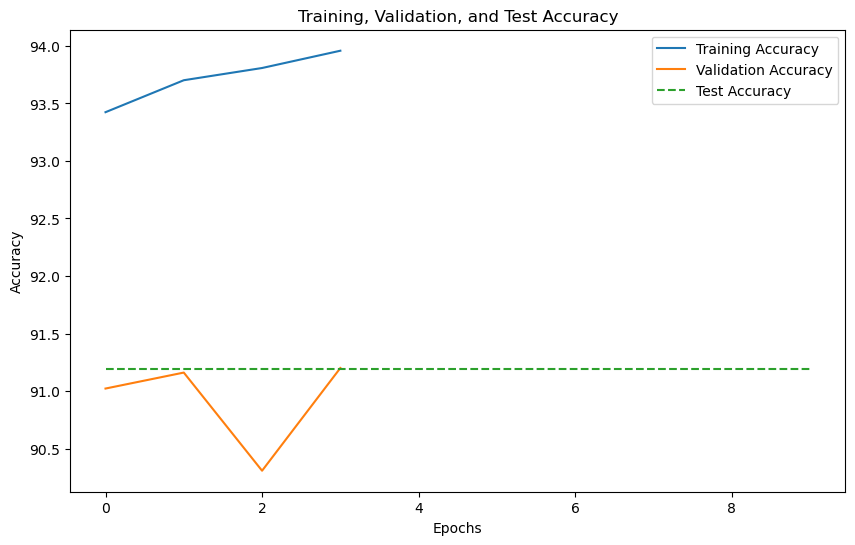

In [26]:

test_accuracy_repeated = [early_stopping_metrics['test_accuracy']] * num_epochs

plt.figure(figsize=(10, 6))
plt.plot(early_stopping_metrics['train_accuracy'], label='Training Accuracy')
plt.plot(early_stopping_metrics['val_accuracy'], label='Validation Accuracy')
plt.plot(test_accuracy_repeated, label='Test Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()
plt.show()


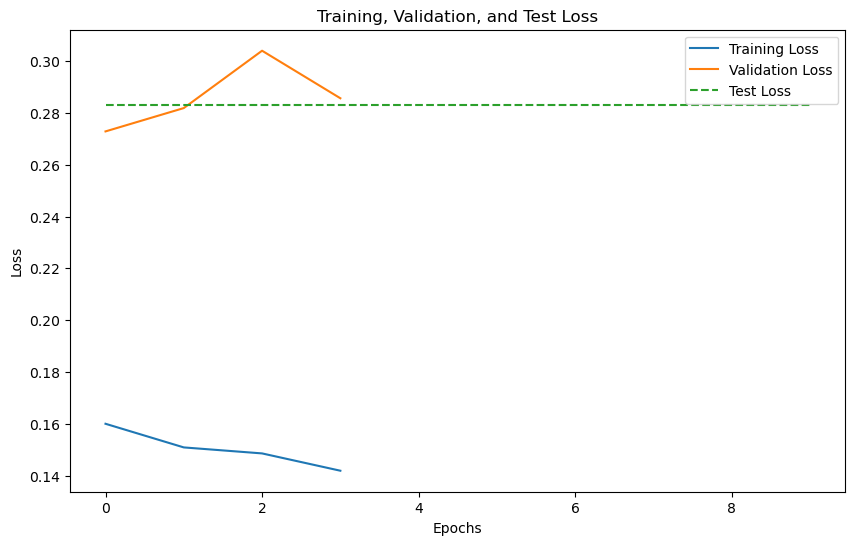

In [27]:
test_loss_repeated = [early_stopping_metrics['test_loss']] * 10

plt.figure(figsize=(10, 6))
plt.plot(early_stopping_metrics['train_loss'], label='Training Loss')
plt.plot(early_stopping_metrics['val_loss'], label='Validation Loss')
plt.plot(test_loss_repeated, label='Test Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.show()


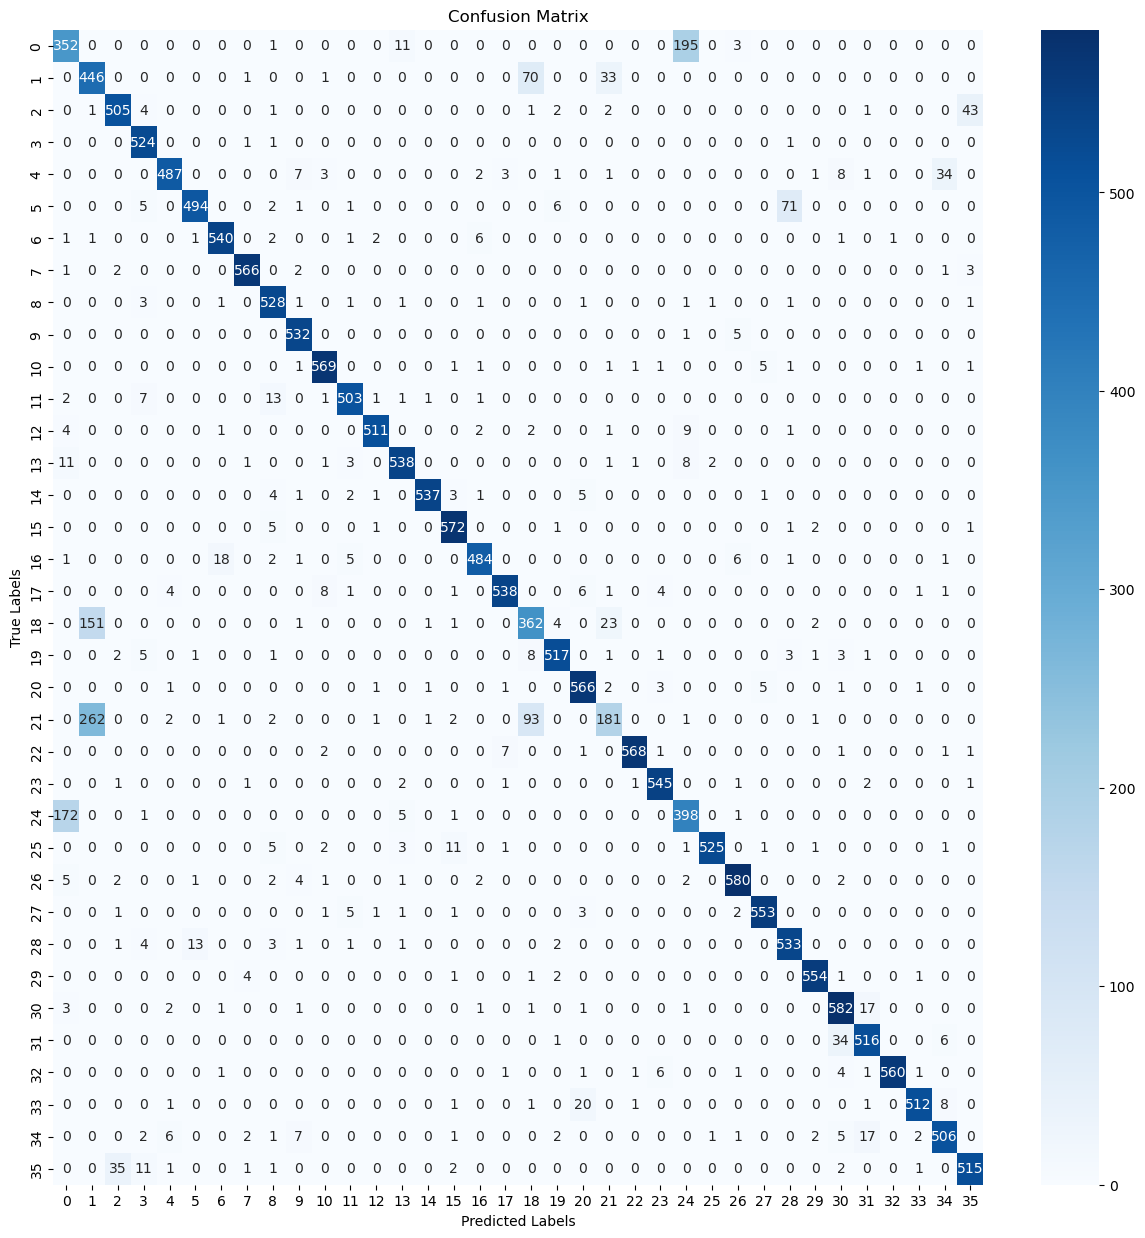

In [28]:
plt.figure(figsize=(15, 15))
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


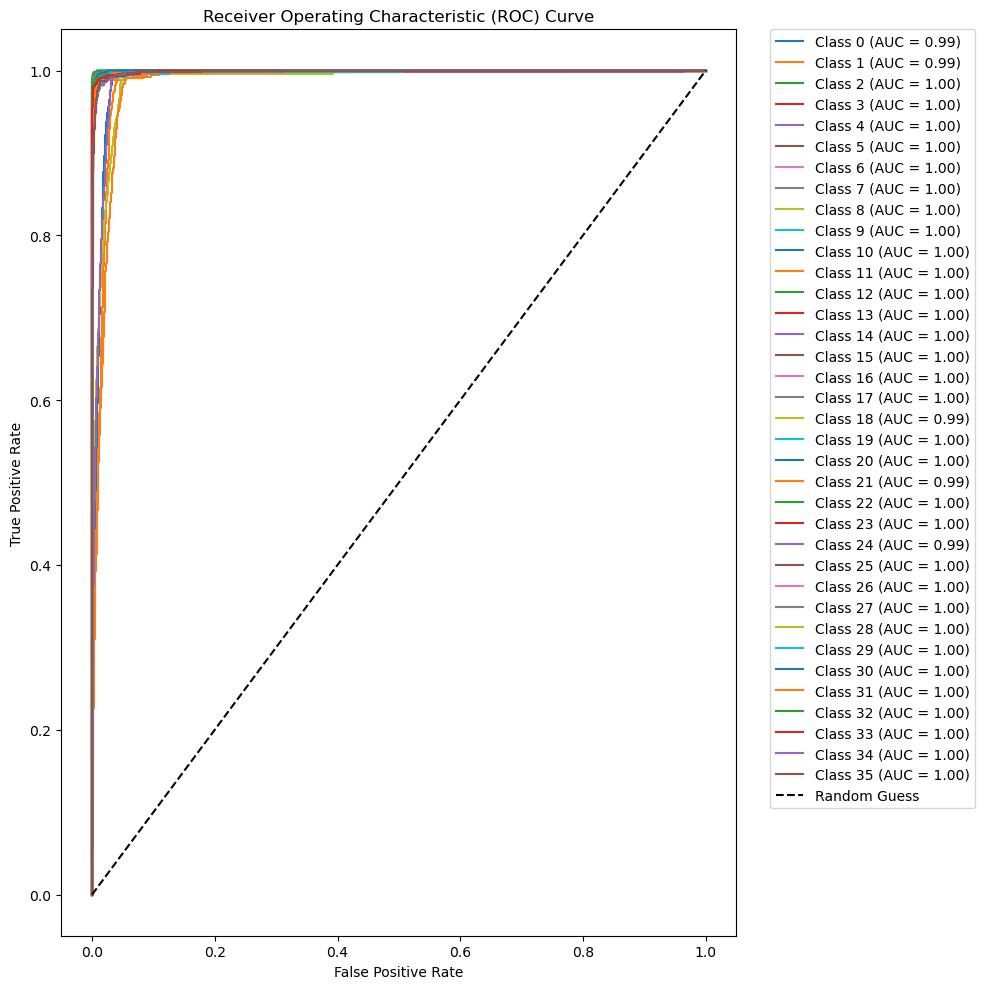

In [29]:
num_classes = len(set(y_true))
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
y_score = np.array(y_score)

plt.figure(figsize=(10, 10))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

#random guess
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

In [30]:
early_stopping_metrics

{'best_val_loss': 0.2728431568587128,
 'best_epoch': 1,
 'epochs_without_improvement': 3,
 'train_loss': [0.16003616841329246,
  0.15091190615741507,
  0.14859764658105462,
  0.1419187813983759],
 'train_accuracy': [93.42403628117914,
  93.70181405895691,
  93.80810657596372,
  93.95833333333333],
 'val_loss': [0.2728431568587128,
  0.28184747315141595,
  0.3039757410017184,
  0.2856348852237946],
 'val_accuracy': [91.02182539682539,
  91.16071428571429,
  90.30753968253968,
  91.20039682539682],
 'total_training_time': 258.3575699329376,
 'test_precision': 0.9145075344312935,
 'test_recall': 0.9119543650793651,
 'test_f1': 0.9115638329474567,
 'test_loss': 0.2830767060556109,
 'test_accuracy': 91.1954365079365}

---

---

# K fold - IMPROVEMENT #2

In [33]:
num_folds = 3
fold_metrics = []

In [34]:
for fold in range(num_folds):
    print(f"Starting fold {fold+1}/{num_folds}...")
    
    model = CNN_basic(num_classes=36).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    kfold_metrics = {
        "train_loss": [],
        "train_accuracy": [],
        "val_loss": [],
        "val_accuracy": [],
        "test_loss": None,
        "test_accuracy": None,
        "total_training_time": None,
        "test_precision": 0,
        "test_recall": 0,
        "test_f1": 0,
        "y_true": [],
        "y_pred": []
    }
    
    start_time = time.time()
    
    for epoch in range(3):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader, desc=f"Fold {fold+1} - Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        
        val_loss, val_accuracy = evaluate_model(val_loader)

        kfold_metrics["train_loss"].append(avg_train_loss)
        kfold_metrics["train_accuracy"].append(train_accuracy)
        kfold_metrics["val_loss"].append(val_loss)
        kfold_metrics["val_accuracy"].append(val_accuracy)

        print(f"Fold {fold+1} - Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    end_time = time.time()
    kfold_metrics["total_training_time"] = end_time - start_time

    test_loss, test_accuracy, test_labels, test_preds = evaluate_model_test(test_loader)
    acc, test_precision, test_recall, test_f1 = calculate_metrics(test_labels, test_preds)

    kfold_metrics["test_loss"] = test_loss
    kfold_metrics["test_accuracy"] = test_accuracy
    kfold_metrics["test_precision"] = test_precision
    kfold_metrics["test_recall"] = test_recall
    kfold_metrics["test_f1"] = test_f1
    kfold_metrics["y_true"].extend(test_labels)
    kfold_metrics["y_pred"].extend(test_preds)
    
    fold_metrics.append(kfold_metrics)

    print(f"Fold {fold+1} complete - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%\n")

torch.save(model.state_dict(), "kfold.pt")


Starting fold 1/3...


Fold 1 - Epoch 1/10: 100%|██████████| 1103/1103 [00:58<00:00, 18.85it/s]


Fold 1 - Epoch [1/10], Train Loss: 0.7352, Train Accuracy: 76.21%, Val Loss: 0.3303, Val Accuracy: 87.91%


Fold 1 - Epoch 2/10: 100%|██████████| 1103/1103 [00:57<00:00, 19.30it/s]


Fold 1 - Epoch [2/10], Train Loss: 0.3187, Train Accuracy: 88.39%, Val Loss: 0.2805, Val Accuracy: 88.92%


Fold 1 - Epoch 3/10: 100%|██████████| 1103/1103 [00:58<00:00, 18.84it/s]


Fold 1 - Epoch [3/10], Train Loss: 0.2687, Train Accuracy: 89.99%, Val Loss: 0.2704, Val Accuracy: 89.98%
Fold 1 complete - Test Loss: 0.2672, Test Accuracy: 90.02%

Starting fold 2/3...


Fold 2 - Epoch 1/10: 100%|██████████| 1103/1103 [00:59<00:00, 18.42it/s]


Fold 2 - Epoch [1/10], Train Loss: 0.7339, Train Accuracy: 76.21%, Val Loss: 0.3374, Val Accuracy: 87.05%


Fold 2 - Epoch 2/10: 100%|██████████| 1103/1103 [00:59<00:00, 18.50it/s]


Fold 2 - Epoch [2/10], Train Loss: 0.3137, Train Accuracy: 88.60%, Val Loss: 0.2660, Val Accuracy: 90.02%


Fold 2 - Epoch 3/10: 100%|██████████| 1103/1103 [01:02<00:00, 17.70it/s]


Fold 2 - Epoch [3/10], Train Loss: 0.2693, Train Accuracy: 90.07%, Val Loss: 0.2822, Val Accuracy: 89.58%
Fold 2 complete - Test Loss: 0.2798, Test Accuracy: 89.60%

Starting fold 3/3...


Fold 3 - Epoch 1/10: 100%|██████████| 1103/1103 [01:03<00:00, 17.28it/s]


Fold 3 - Epoch [1/10], Train Loss: 0.7106, Train Accuracy: 77.01%, Val Loss: 0.3149, Val Accuracy: 88.21%


Fold 3 - Epoch 2/10: 100%|██████████| 1103/1103 [01:03<00:00, 17.33it/s]


Fold 3 - Epoch [2/10], Train Loss: 0.3094, Train Accuracy: 88.83%, Val Loss: 0.2876, Val Accuracy: 89.39%


Fold 3 - Epoch 3/10: 100%|██████████| 1103/1103 [01:06<00:00, 16.51it/s]


Fold 3 - Epoch [3/10], Train Loss: 0.2638, Train Accuracy: 90.12%, Val Loss: 0.2612, Val Accuracy: 90.25%
Fold 3 complete - Test Loss: 0.2557, Test Accuracy: 90.52%



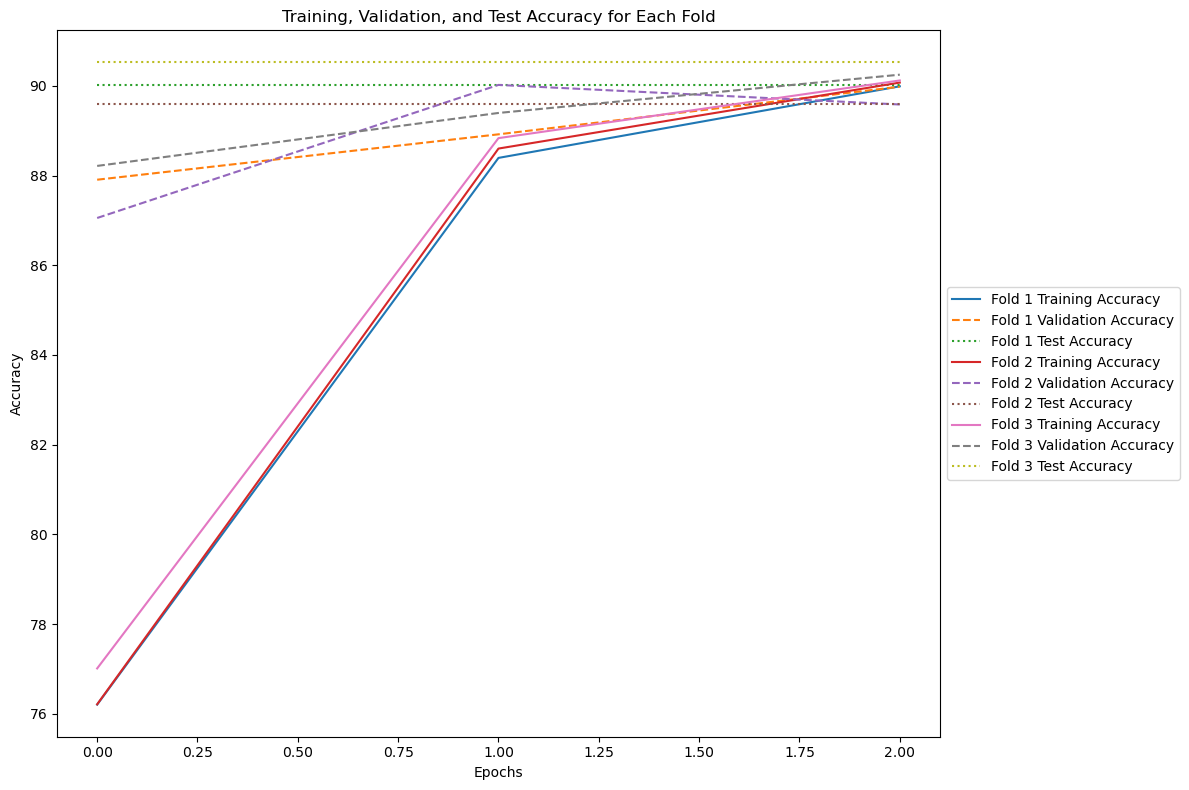

In [35]:
plt.figure(figsize=(12, 8))

#each fold in fold_metrics
for i, fold in enumerate(fold_metrics):
    num_epochs = len(fold["train_accuracy"])
    test_accuracy_repeated = [fold['test_accuracy']] * num_epochs

    plt.plot(fold['train_accuracy'], label=f'Fold {i+1} Training Accuracy', linestyle='-')
    plt.plot(fold['val_accuracy'], label=f'Fold {i+1} Validation Accuracy', linestyle='--')
    plt.plot(test_accuracy_repeated, label=f'Fold {i+1} Test Accuracy', linestyle=':')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy for Each Fold')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.tight_layout()
plt.show()


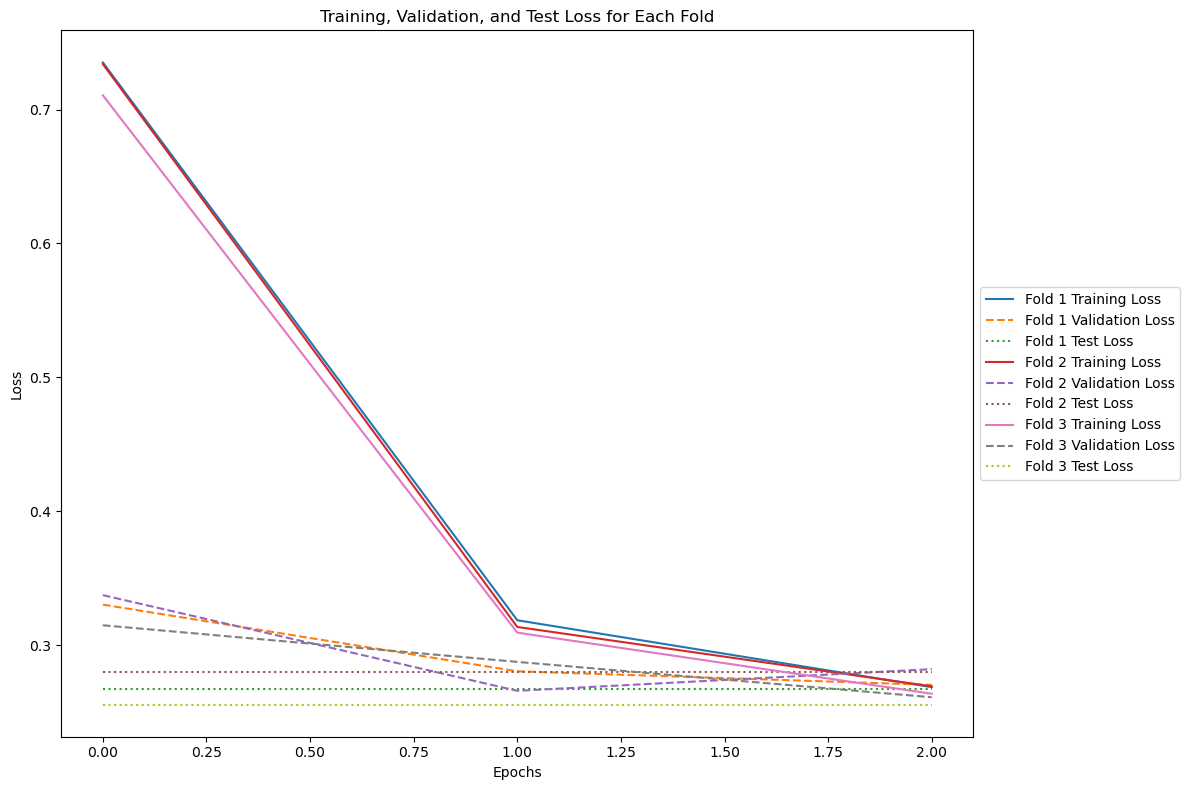

In [36]:
plt.figure(figsize=(12, 8))

#each fold in fold_metrics
for i, fold in enumerate(fold_metrics):
    num_epochs = len(fold["train_loss"])
    test_loss_repeated = [fold['test_loss']] * num_epochs

   
    plt.plot(fold['train_loss'], label=f'Fold {i+1} Training Loss', linestyle='-')
    plt.plot(fold['val_loss'], label=f'Fold {i+1} Validation Loss', linestyle='--')
    plt.plot(test_loss_repeated, label=f'Fold {i+1} Test Loss', linestyle=':')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss for Each Fold')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.tight_layout()
plt.show()


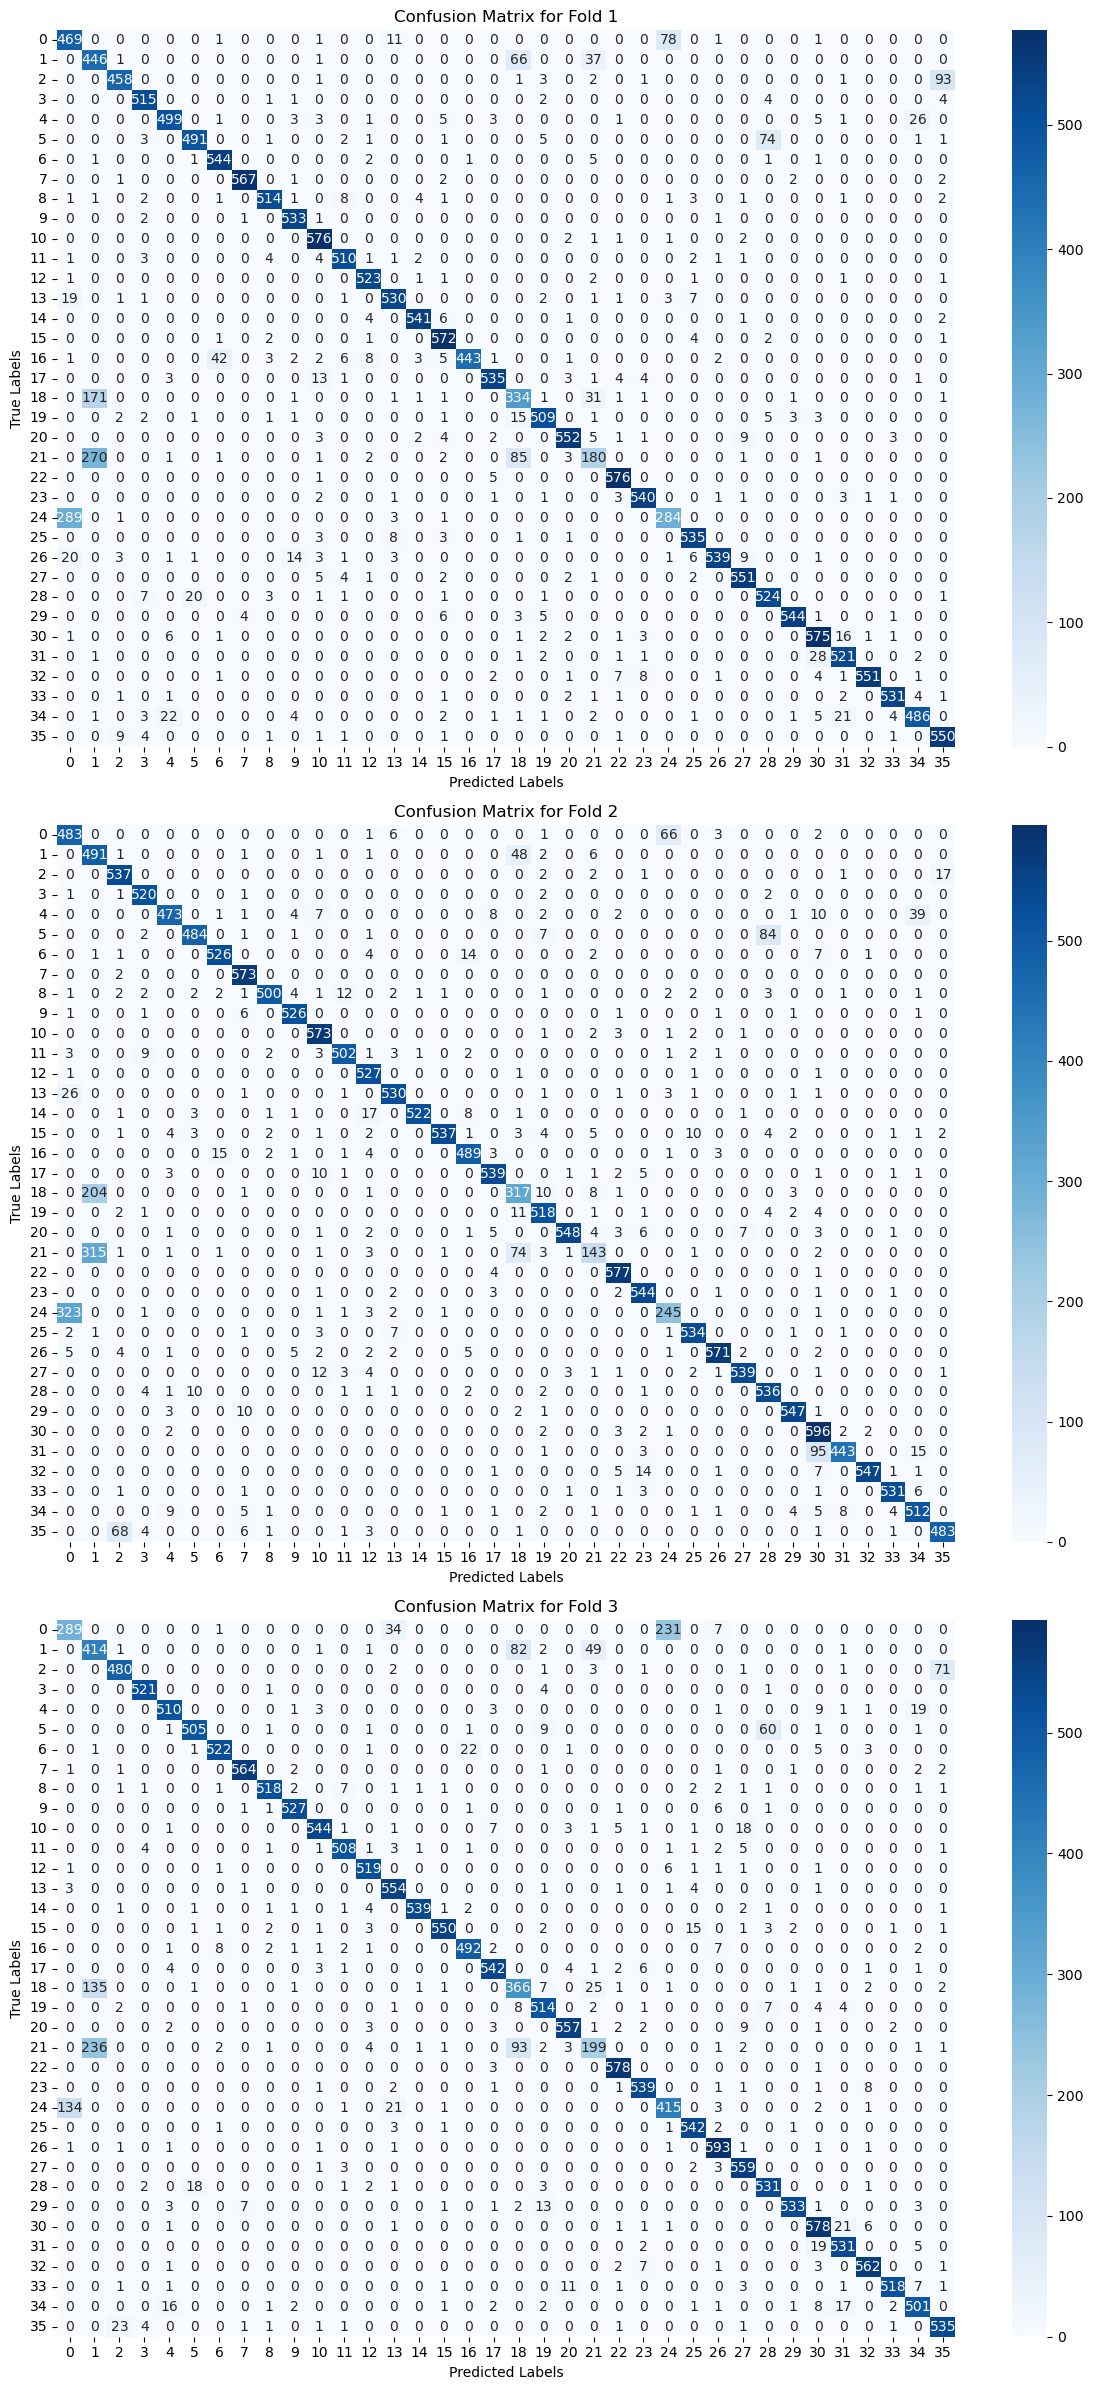

In [37]:
plt.figure(figsize=(12, 8 * len(fold_metrics)))  

for i, fold in enumerate(fold_metrics):
    y_true = fold['y_true']
    y_pred = fold['y_pred']
    
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    plt.subplot(len(fold_metrics), 1, i + 1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for Fold {i + 1}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

plt.tight_layout()
plt.show()


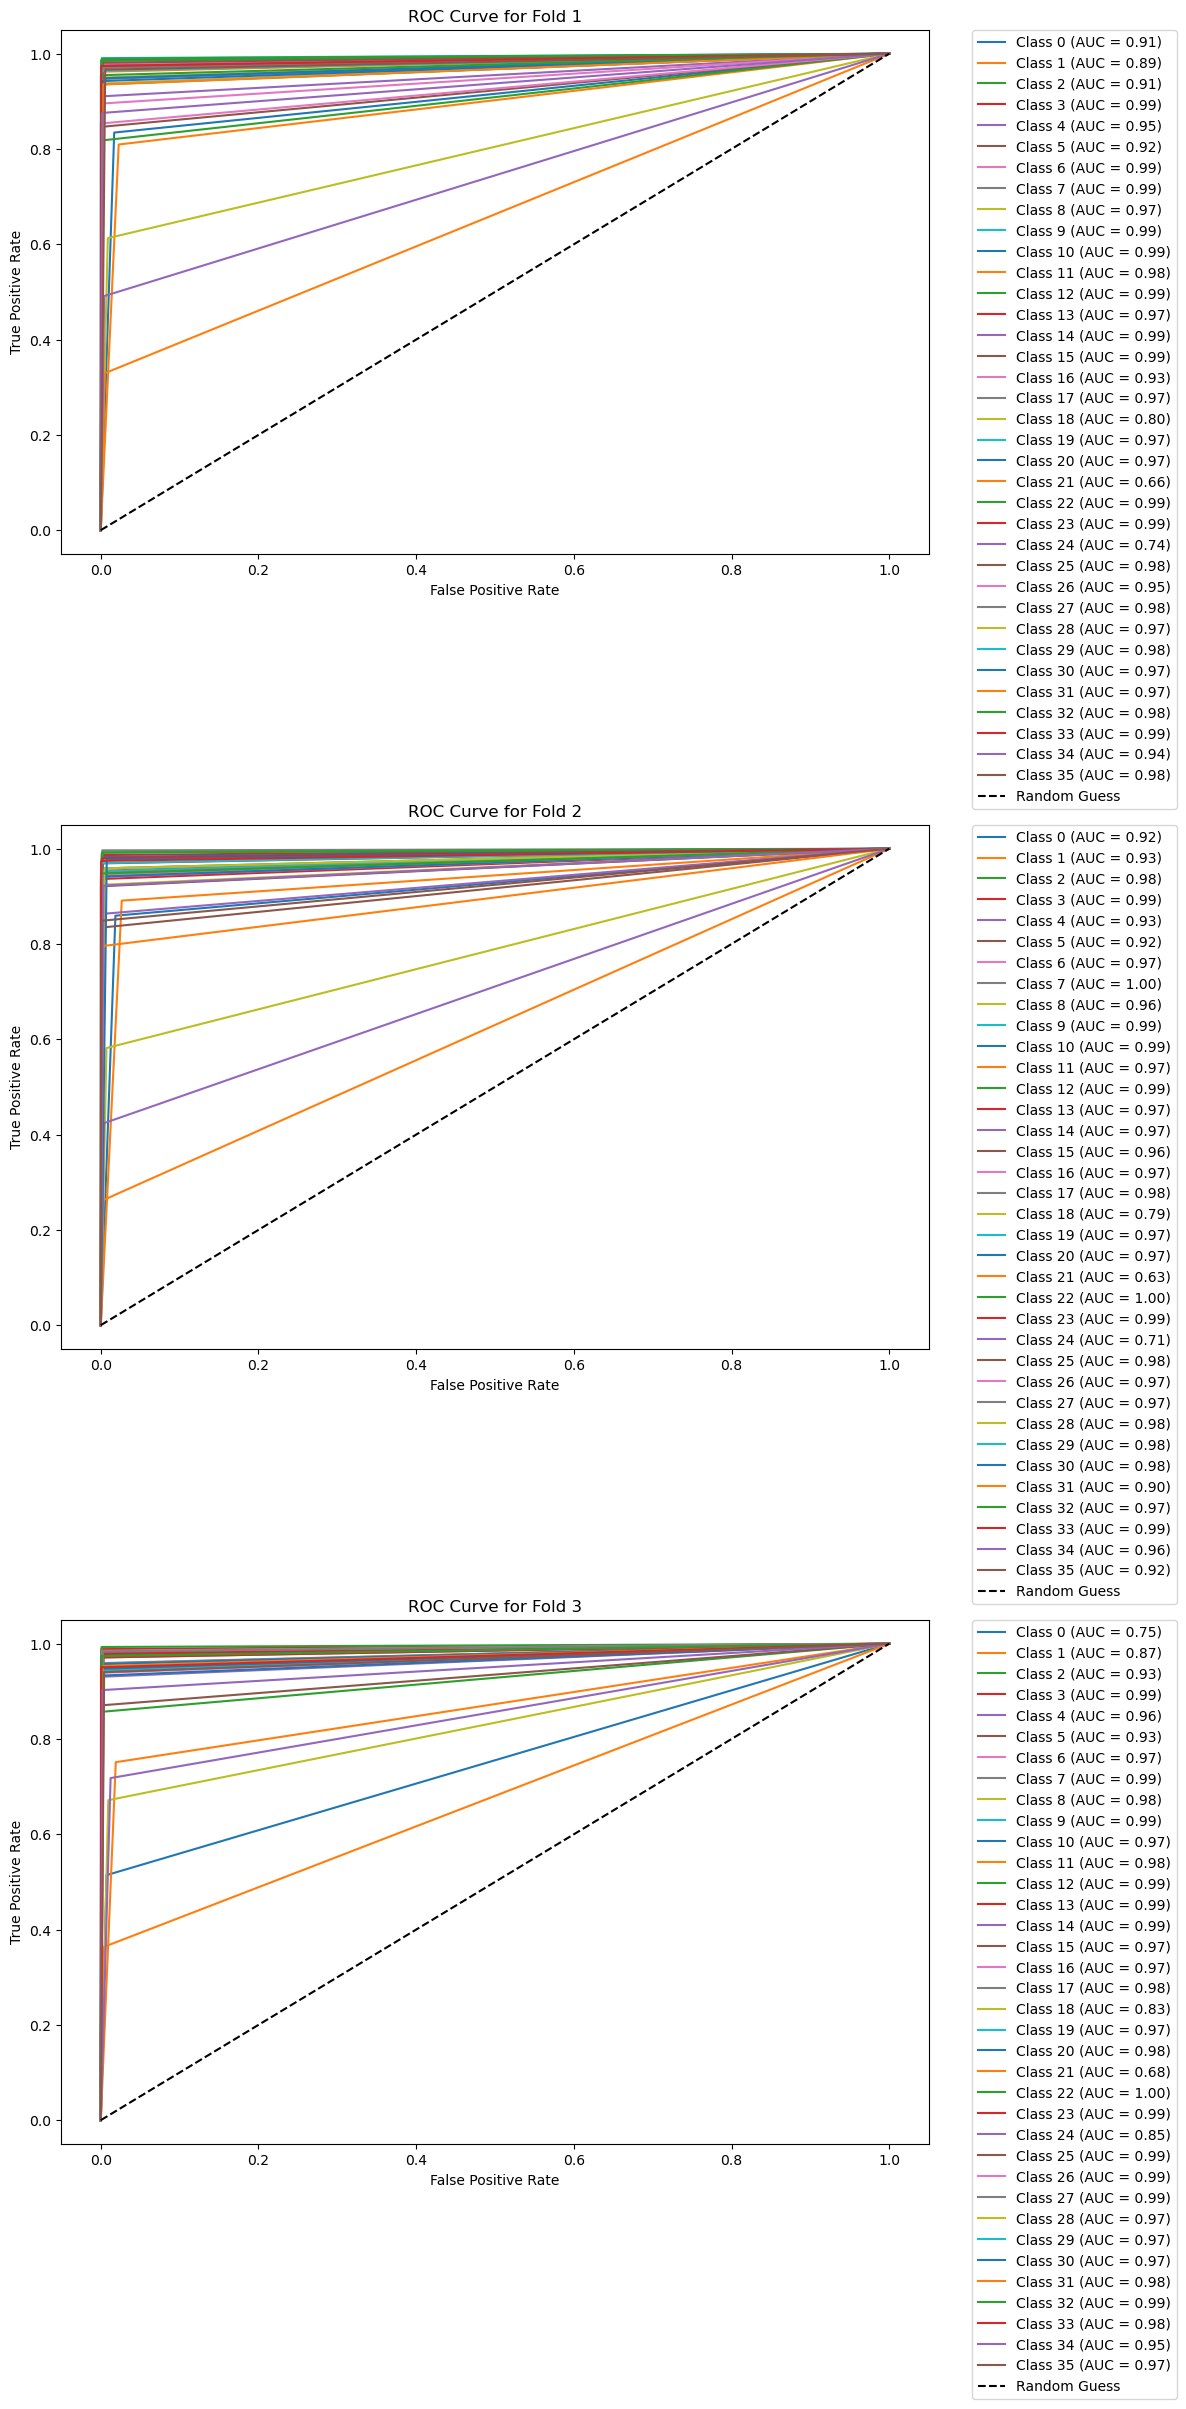

In [38]:
num_classes = 36

plt.figure(figsize=(12, 8 * len(fold_metrics)))

#ROC curve each fold
for i, fold in enumerate(fold_metrics):
    y_true = fold['y_true']
    y_pred = fold['y_pred']

    
    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
    y_pred_bin = label_binarize(y_pred, classes=np.arange(num_classes))

    plt.subplot(len(fold_metrics), 1, i + 1)
    for j in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, j], y_pred_bin[:, j])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {j} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Fold {i + 1}')
    plt.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

plt.tight_layout()
plt.show()


---

---

# Learning rate scheduler - IMPROVEMENT #3

In [ ]:
model = CNN_basic(num_classes=36).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

step_size = 5
gamma = 0.1
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

num_epochs = 10 
scheduler_metrics = {
    "train_loss": [],
    "train_accuracy": [],
    "val_loss": [],
    "val_accuracy": [],
    "learning_rate": [],
    "training_time": None,
    "test_precision":0,
    "test_recall":0,
    "test_f1":0
}

In [43]:

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        #training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    val_loss, val_accuracy = evaluate_model(val_loader)

    scheduler_metrics["train_loss"].append(avg_train_loss)
    scheduler_metrics["train_accuracy"].append(train_accuracy)
    scheduler_metrics["val_loss"].append(val_loss)
    scheduler_metrics["val_accuracy"].append(val_accuracy)

    current_lr = optimizer.param_groups[0]["lr"]
    scheduler_metrics["learning_rate"].append(current_lr)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, "
          f"Learning Rate: {current_lr:.6f}")

    #step the scheduler at the end
    scheduler.step()

end_time = time.time()
total_training_time = end_time - start_time
scheduler_metrics["training_time"] = total_training_time

print(f"Total training time: {total_training_time:.2f} seconds")

print("Training complete.")
torch.save(model.state_dict(), "scheduler.pt")

Epoch 1/10: 100%|██████████| 1103/1103 [00:58<00:00, 18.91it/s]


Epoch [1/10], Train Loss: 0.6840, Train Accuracy: 77.54%, Val Loss: 0.3101, Val Accuracy: 88.21%, Learning Rate: 0.001000


Epoch 2/10: 100%|██████████| 1103/1103 [00:59<00:00, 18.57it/s]


Epoch [2/10], Train Loss: 0.3122, Train Accuracy: 88.61%, Val Loss: 0.2770, Val Accuracy: 89.80%, Learning Rate: 0.001000


Epoch 3/10: 100%|██████████| 1103/1103 [00:59<00:00, 18.55it/s]


Epoch [3/10], Train Loss: 0.2639, Train Accuracy: 90.07%, Val Loss: 0.2798, Val Accuracy: 89.84%, Learning Rate: 0.001000


Epoch 4/10: 100%|██████████| 1103/1103 [01:03<00:00, 17.29it/s]


Epoch [4/10], Train Loss: 0.2386, Train Accuracy: 90.91%, Val Loss: 0.2596, Val Accuracy: 90.24%, Learning Rate: 0.001000


Epoch 5/10: 100%|██████████| 1103/1103 [01:08<00:00, 16.02it/s]


Epoch [5/10], Train Loss: 0.2214, Train Accuracy: 91.37%, Val Loss: 0.2590, Val Accuracy: 90.64%, Learning Rate: 0.001000


Epoch 6/10: 100%|██████████| 1103/1103 [01:06<00:00, 16.60it/s]


Epoch [6/10], Train Loss: 0.1635, Train Accuracy: 93.34%, Val Loss: 0.2290, Val Accuracy: 91.68%, Learning Rate: 0.000100


Epoch 7/10: 100%|██████████| 1103/1103 [01:09<00:00, 15.95it/s]


Epoch [7/10], Train Loss: 0.1482, Train Accuracy: 93.83%, Val Loss: 0.2341, Val Accuracy: 91.66%, Learning Rate: 0.000100


Epoch 8/10: 100%|██████████| 1103/1103 [01:10<00:00, 15.57it/s]


Epoch [8/10], Train Loss: 0.1405, Train Accuracy: 94.20%, Val Loss: 0.2354, Val Accuracy: 91.57%, Learning Rate: 0.000100


Epoch 9/10: 100%|██████████| 1103/1103 [01:11<00:00, 15.45it/s]


Epoch [9/10], Train Loss: 0.1355, Train Accuracy: 94.26%, Val Loss: 0.2402, Val Accuracy: 91.70%, Learning Rate: 0.000100


Epoch 10/10: 100%|██████████| 1103/1103 [01:12<00:00, 15.26it/s]


Epoch [10/10], Train Loss: 0.1292, Train Accuracy: 94.55%, Val Loss: 0.2441, Val Accuracy: 91.71%, Learning Rate: 0.000100
Total training time: 711.42 seconds
Training complete.


In [44]:
test_loss, test_accuracy, test_labels, test_preds = evaluate_model_test(test_loader)
acc, test_precision, test_recall, test_f1 = calculate_metrics(test_labels, test_preds)

scheduler_metrics["test_loss"] = test_loss
scheduler_metrics["test_accuracy"] = test_accuracy
scheduler_metrics["test_precision"] = test_precision
scheduler_metrics["test_recall"] = test_recall
scheduler_metrics["test_f1"] = test_f1

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 0.2315, Test Accuracy: 91.86%


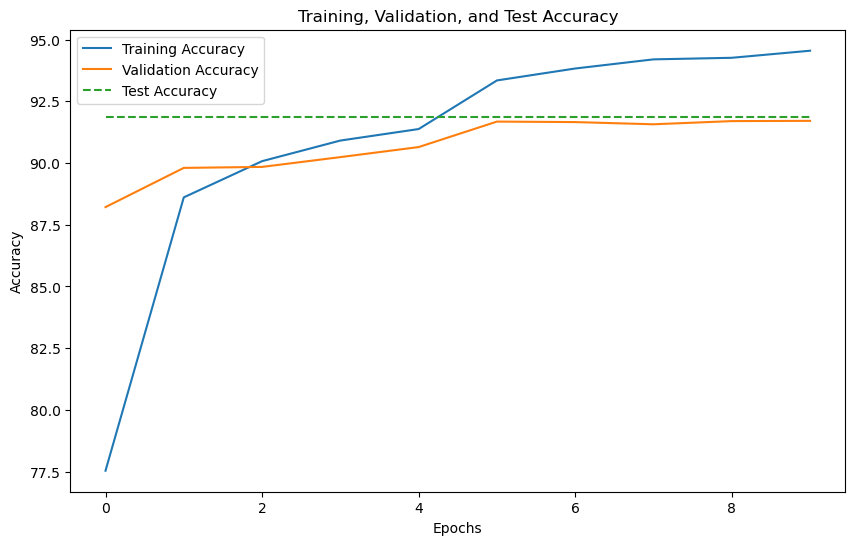

In [45]:

test_accuracy_repeated = [scheduler_metrics['test_accuracy']] * num_epochs

plt.figure(figsize=(10, 6))
plt.plot(scheduler_metrics['train_accuracy'], label='Training Accuracy')
plt.plot(scheduler_metrics['val_accuracy'], label='Validation Accuracy')
plt.plot(test_accuracy_repeated, label='Test Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()
plt.show()


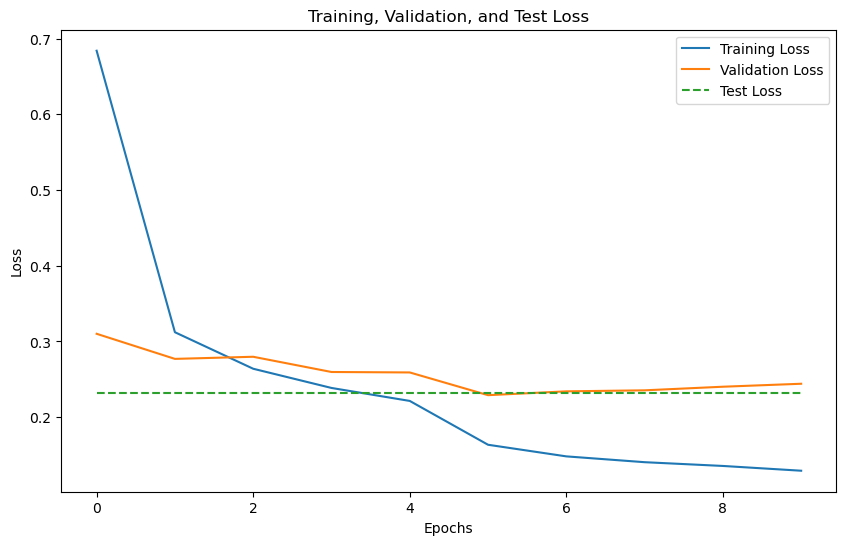

In [47]:
test_loss_repeated = [scheduler_metrics['test_loss']] * num_epochs

plt.figure(figsize=(10, 6))
plt.plot(scheduler_metrics['train_loss'], label='Training Loss')
plt.plot(scheduler_metrics['val_loss'], label='Validation Loss')
plt.plot(test_loss_repeated, label='Test Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.show()


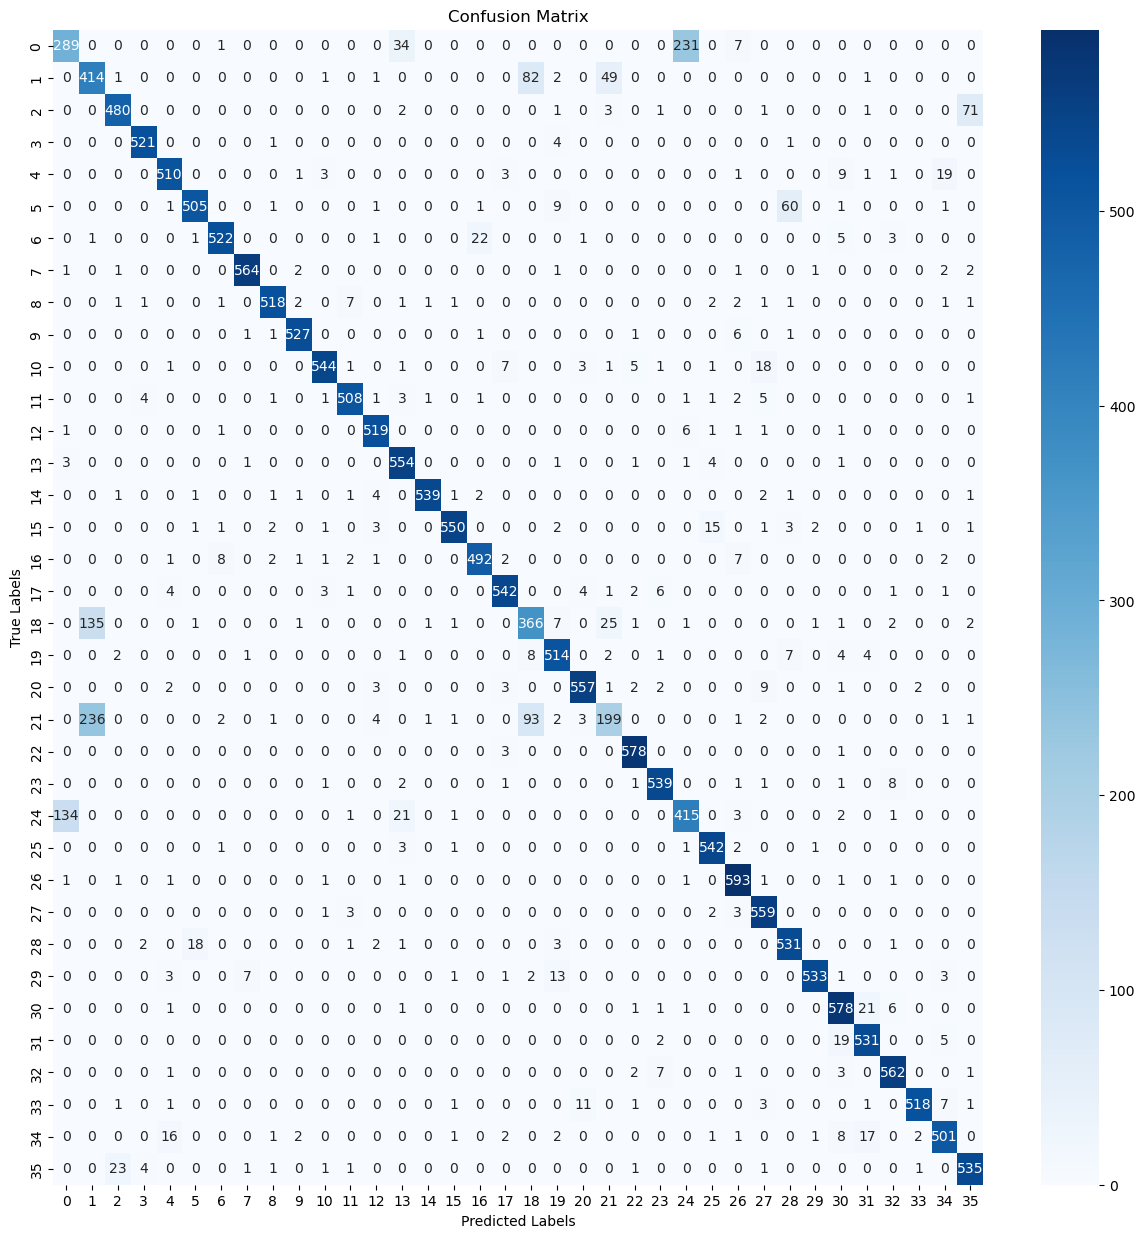

In [48]:
#Confusion Matrix
plt.figure(figsize=(15, 15))
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



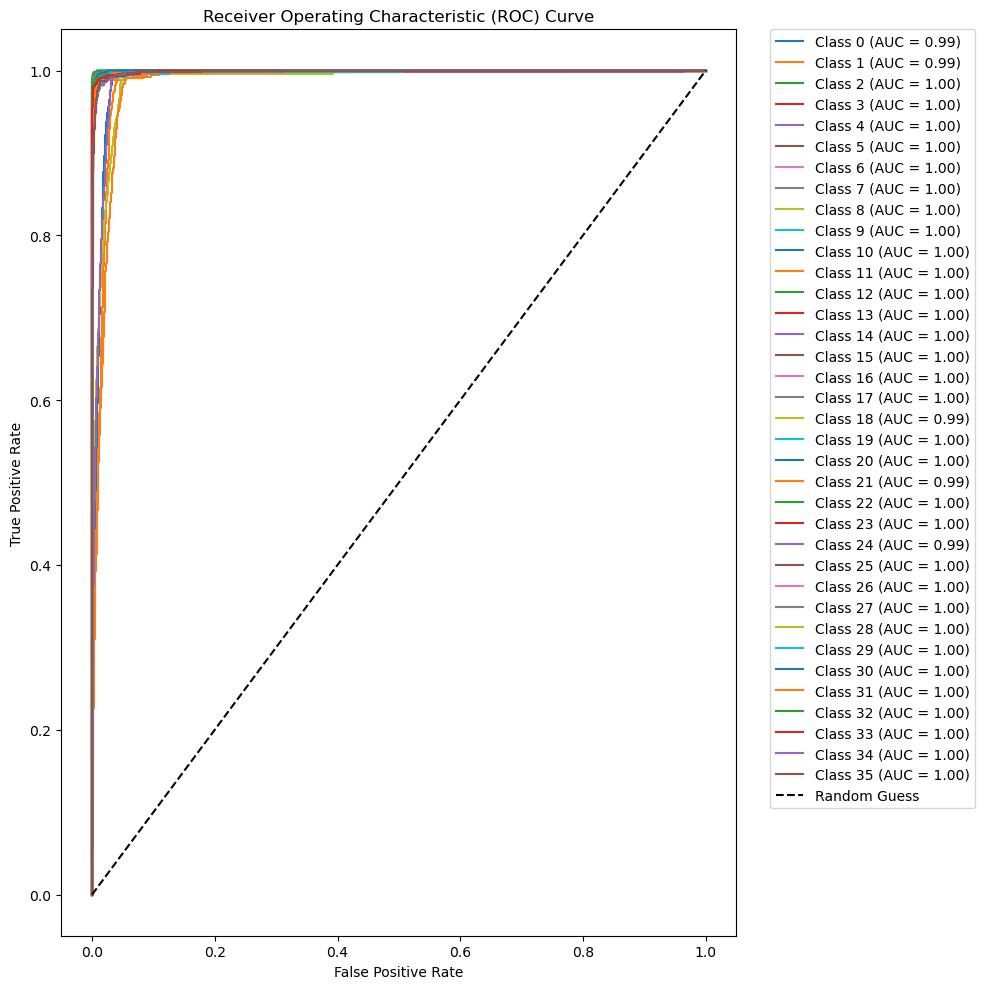

In [49]:
num_classes = len(set(y_true)) 
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
y_score = np.array(y_score)

plt.figure(figsize=(10, 10))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

#random guess
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

In [50]:
scheduler_metrics

{'train_loss': [0.6840380695821584,
  0.3121818471649292,
  0.2639347040453286,
  0.2385642931459713,
  0.22142358123242908,
  0.16352320670176396,
  0.14817367203986223,
  0.14049161990879885,
  0.13552667331440224,
  0.1292243404423688],
 'train_accuracy': [77.53826530612245,
  88.60827664399093,
  90.07369614512471,
  90.90844671201815,
  91.37471655328798,
  93.34325396825396,
  93.8265306122449,
  94.19642857142857,
  94.26020408163265,
  94.54648526077098],
 'val_loss': [0.31011221279637724,
  0.2769590037627311,
  0.27976048200190823,
  0.2596478870350726,
  0.2590451161789743,
  0.22902791283411694,
  0.23408216538638632,
  0.23541902413568164,
  0.24018503608818673,
  0.244112582635606],
 'val_accuracy': [88.21428571428571,
  89.8015873015873,
  89.84126984126983,
  90.23809523809524,
  90.64484126984127,
  91.6765873015873,
  91.65674603174604,
  91.56746031746032,
  91.69642857142857,
  91.7063492063492],
 'learning_rate': [0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.0001

---

# The best model accordingly is Learning rate scheduler,  we have plotted accuracy, loss, confusion matrix and ROC for all three improvements and saved our weights as well. 